## Project n°8: **On joint parameterizations of linear and nonlinear functionals in neural networks**

### Imports

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
#import wget
import zipfile
import itertools

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa

import keras
from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping

from keras import layers
from keras import activations

from keras.layers import Input, Concatenate, Dense, Flatten, Reshape, Lambda, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import plot_model
from keras.applications import EfficientNetB0, NASNetMobile, Xception, ResNet50
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import tensorflow as tf

from keras import layers
from keras import activations

import cv2

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

### Definition of transfer functions

In [ ]:
# define the sign function
def sign(x):
  return tf.math.sign(x)

In [ ]:
# define the indicator function
def indic(x, lamb):
  return float(int(x >= lamb))

In [ ]:
# define the Rectified Parametric Sigmoid shrinKage Units (RePSKU or RePSU▽)
def RePSKU(x, lamb, mu, sigma, beta):
  numerator = (x-lamb) * indic(x, lamb)
  denominator = 1 + tf.math.exp(-sign(x-mu)*(tf.math.abs(x-mu)/sigma)**beta)
  return numerator/denominator

In [ ]:
# define the Rectified Parametric Sigmoid shrinKage Units (RePSKU or RePSU▽)
def RePSKU_static(x, mu, sigma, beta):
  numerator = x * indic(x, 0)
  denominator = 1 + tf.math.exp(-sign(x-mu)*(tf.math.abs(x-mu)/sigma)**beta)
  return numerator/denominator

In [ ]:
# define the Rectified Parametric Sigmoid shrinKage Units (RePSKU or RePSU▽)
def RePSKU_no_beta(x, lamb, mu, sigma):
  numerator = (x-lamb) * indic(x, lamb)
  denominator = 1 + tf.math.exp(-sign(x-mu)*tf.math.abs(x-mu)/sigma)
  return numerator/denominator

In [ ]:
# define the Rectified Parametric Sigmoid stretcHage Units (RePSHU or RePSU△)
def RePSHU(x, lamb, mu, sigma, beta):
  return 2 * x * indic(x, lamb) - RePSKU(x, lamb, mu, sigma, beta)

In [ ]:
# define the Rectified Parametric Sigmoid Unit (RePSU):
def RePSU(x, lamb, mu, sigma, beta, alpha):
  return alpha * RePSHU(x, lamb, mu, sigma, beta) + (1-alpha) * RePSKU(x, lamb, mu, sigma, beta)

In [ ]:
# define the MISH activation function
def mish(x):
    return x * tf.math.tanh(tf.math.log(1 + tf.math.exp(x)))

In [ ]:
# define the PMISH activation function
def pmish(x, eps):
    return x * tf.math.tanh((1/eps)*tf.math.log(1 + tf.math.exp(eps*x)))

In [ ]:
# define the SWISH activation function
def swish(x):
    return x * tf.math.sigmoid(x)

In [ ]:
# define the PSWISH activation function
def pswish(x, eps):
    return x * tf.math.sigmoid(eps*x)

In [ ]:
# define the ReLU function
def relu(x):
    return tf.math.maximum(0.0, x)

In [ ]:
class ParametricReLU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ParametricReLU, self).__init__(**kwargs)
        self.alpha = None

    def build(self, input_shape):
        self.alpha = self.add_weight(
            name='alpha',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )
        super(ParametricReLU, self).build(input_shape)

    def call(self, X):
        return tf.maximum(X, 0) + self.alpha * tf.minimum(X, 0)


class ParametricSwish(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ParametricSwish, self).__init__(**kwargs)
        self.eps = None

    def build(self, input_shape):
        self.eps = self.add_weight(
            name='eps',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )
        super(ParametricSwish, self).build(input_shape)

    def call(self, X):
        return pswish(X, self.eps)


class ParametricMish(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ParametricMish, self).__init__(**kwargs)
        self.eps = None

    def build(self, input_shape):
        self.eps = self.add_weight(
            name='eps',
            shape=(1,),
            initializer='ones',
            trainable=True
        )
        super(ParametricMish, self).build(input_shape)

    #def call(self, X):
        #return X * tf.math.tanh((1/self.eps) * tf.math.log(1 + tf.math.exp(self.eps*X)))

    def call(self, X):
        # handle case where eps is negative
        #pos = tf.math.log(1 + tf.math.exp(self.eps * X))
        #neg = tf.math.log(1 + tf.math.exp(-self.eps * X))
        #return X * tf.math.tanh(tf.where(self.eps >= 0, (1/self.eps) * pos, (-1/self.eps) * neg))

        if self.eps > 0:
          return pmish(X, self.eps)
          #return X * tf.math.tanh((1/self.eps) * tf.math.log(1 + tf.math.exp(self.eps*X)))
        elif self.eps < 0:
          return pmish(X, -self.eps)
          #return X * tf.math.tanh((-1/self.eps) * tf.math.log(1 + tf.math.exp(-self.eps*X)))
        else:
          return X * 0

class ParametricRePSU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ParametricRePSU, self).__init__(**kwargs)
        self.lamb = None
        self.mu = None
        self.sigma = None
        self.beta = None
        self.alpha = None

        #def RePSU(x, lamb, mu, sigma, beta, alpha):
          #return alpha * RePSHU(x, lamb, mu, sigma, beta) + (1-alpha) * RePSKU(x, lamb, mu, sigma, beta)

    def build(self, input_shape):
        self.lamb = self.add_weight(
            name='lamb',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )
        self.mu = self.add_weight(
            name='mu',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )
        self.sigma = self.add_weight(
            name='sigma',
            shape=(1,),
            initializer='ones',
            trainable=True
        )

        self.beta = self.add_weight(
            name='beta',
            shape=(1,),
            initializer='ones',
            trainable=True
        )
        self.alpha = self.add_weight(
            name='alpha',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )
        super(ParametricRePSU, self).build(input_shape)

    def call(self, X):
        if self.beta > 0:
          return RePSU(X, self.lamb, self.mu, self.sigma, self.beta, self.alpha)
        elif self.beta < 0:
          return RePSU(X, self.lamb, self.mu, self.sigma, -self.beta, self.alpha)
        else:
          return X * 0

class ParametricRePSKU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ParametricRePSKU, self).__init__(**kwargs)
        self.lamb = None
        self.mu = None
        self.sigma = None
        self.beta = None

    def build(self, input_shape):

        self.lamb = self.add_weight(
            name='lamb',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )
        self.mu = self.add_weight(
            name='mu',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )
        self.sigma = self.add_weight(
            name='sigma',
            shape=(1,),
            initializer='ones',
            trainable=True
        )
        self.beta = self.add_weight(
            name='beta',
            shape=(1,),
            initializer='ones',
            trainable=True
        )
        super(ParametricRePSKU, self).build(input_shape)

    def call(self, X):
        self.lamb.assign(tf.clip_by_value(self.lamb, -10.0, 10.0))
        self.mu.assign(tf.clip_by_value(self.mu, -10.0, 10.0))
        self.sigma.assign(tf.clip_by_value(self.sigma, -10.0, 10.0))
        self.beta.assign(tf.clip_by_value(self.beta, -20.0, 20.0))



        if -0.5 <= self.sigma <= 0.5:
          self.sigma.assign(tf.constant(0.1, dtype=tf.float32))
          self.sigma.assign(tf.maximum(self.sigma, 0.5))

        if -1.0 <= self.beta <= 1.0:
          self.beta.assign(tf.constant(0.1, dtype=tf.float32))
          self.beta.assign(tf.maximum(self.beta, 1.0))


        if tf.math.greater(self.beta, 0):
          if tf.math.greater(self.sigma, 0):
            return RePSKU(X, self.lamb, self.mu, self.sigma, self.beta)
          elif tf.math.less(self.sigma, 0):
            return RePSKU(X, self.lamb, self.mu, -self.sigma, self.beta)
          else:
            return X * 0

        elif tf.math.less(self.beta, 0):
          if tf.math.greater(self.sigma, 0):
            return RePSKU(X, self.lamb, self.mu, self.sigma, -self.beta)
          elif tf.math.less(self.sigma, 0):
            return RePSKU(X, self.lamb, self.mu, -self.sigma, -self.beta)
          else:
            return X * 0

        else:
          return X * 0

class ParametricRePSKU_no_beta(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ParametricRePSKU_no_beta, self).__init__(**kwargs)
        self.lamb = None
        self.mu = None
        self.sigma = None
        #self.beta = None

    def build(self, input_shape):

        self.lamb = self.add_weight(
            name='lamb',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )
        self.mu = self.add_weight(
            name='mu',
            shape=(1,),
            initializer='zeros',
            trainable=True
        )
        self.sigma = self.add_weight(
            name='sigma',
            shape=(1,),
            initializer='ones',
            trainable=True
        )
        """
        self.beta = self.add_weight(
            name='beta',
            shape=(1,),
            initializer='ones',
            trainable=True
        )"""
        super(ParametricRePSKU_no_beta, self).build(input_shape)

    def call(self, X):
        self.lamb.assign(tf.clip_by_value(self.lamb, -10.0, 10.0))
        self.mu.assign(tf.clip_by_value(self.mu, -10.0, 10.0))
        self.sigma.assign(tf.clip_by_value(self.sigma, -10.0, 10.0))


        if -0.5 <= self.sigma <= 0.5:
          #self.sigma.assign(tf.constant(0.1, dtype=tf.float32))
          self.sigma.assign(tf.maximum(self.sigma, 0.5))



        if tf.math.greater(self.sigma, 0):
          return RePSKU_no_beta(X, self.lamb, self.mu, self.sigma)
        elif tf.math.less(self.sigma, 0):
          return RePSKU_no_beta(X, self.lamb, self.mu, -self.sigma)
        else:
          return X * 0


### Visualization of RePSU function

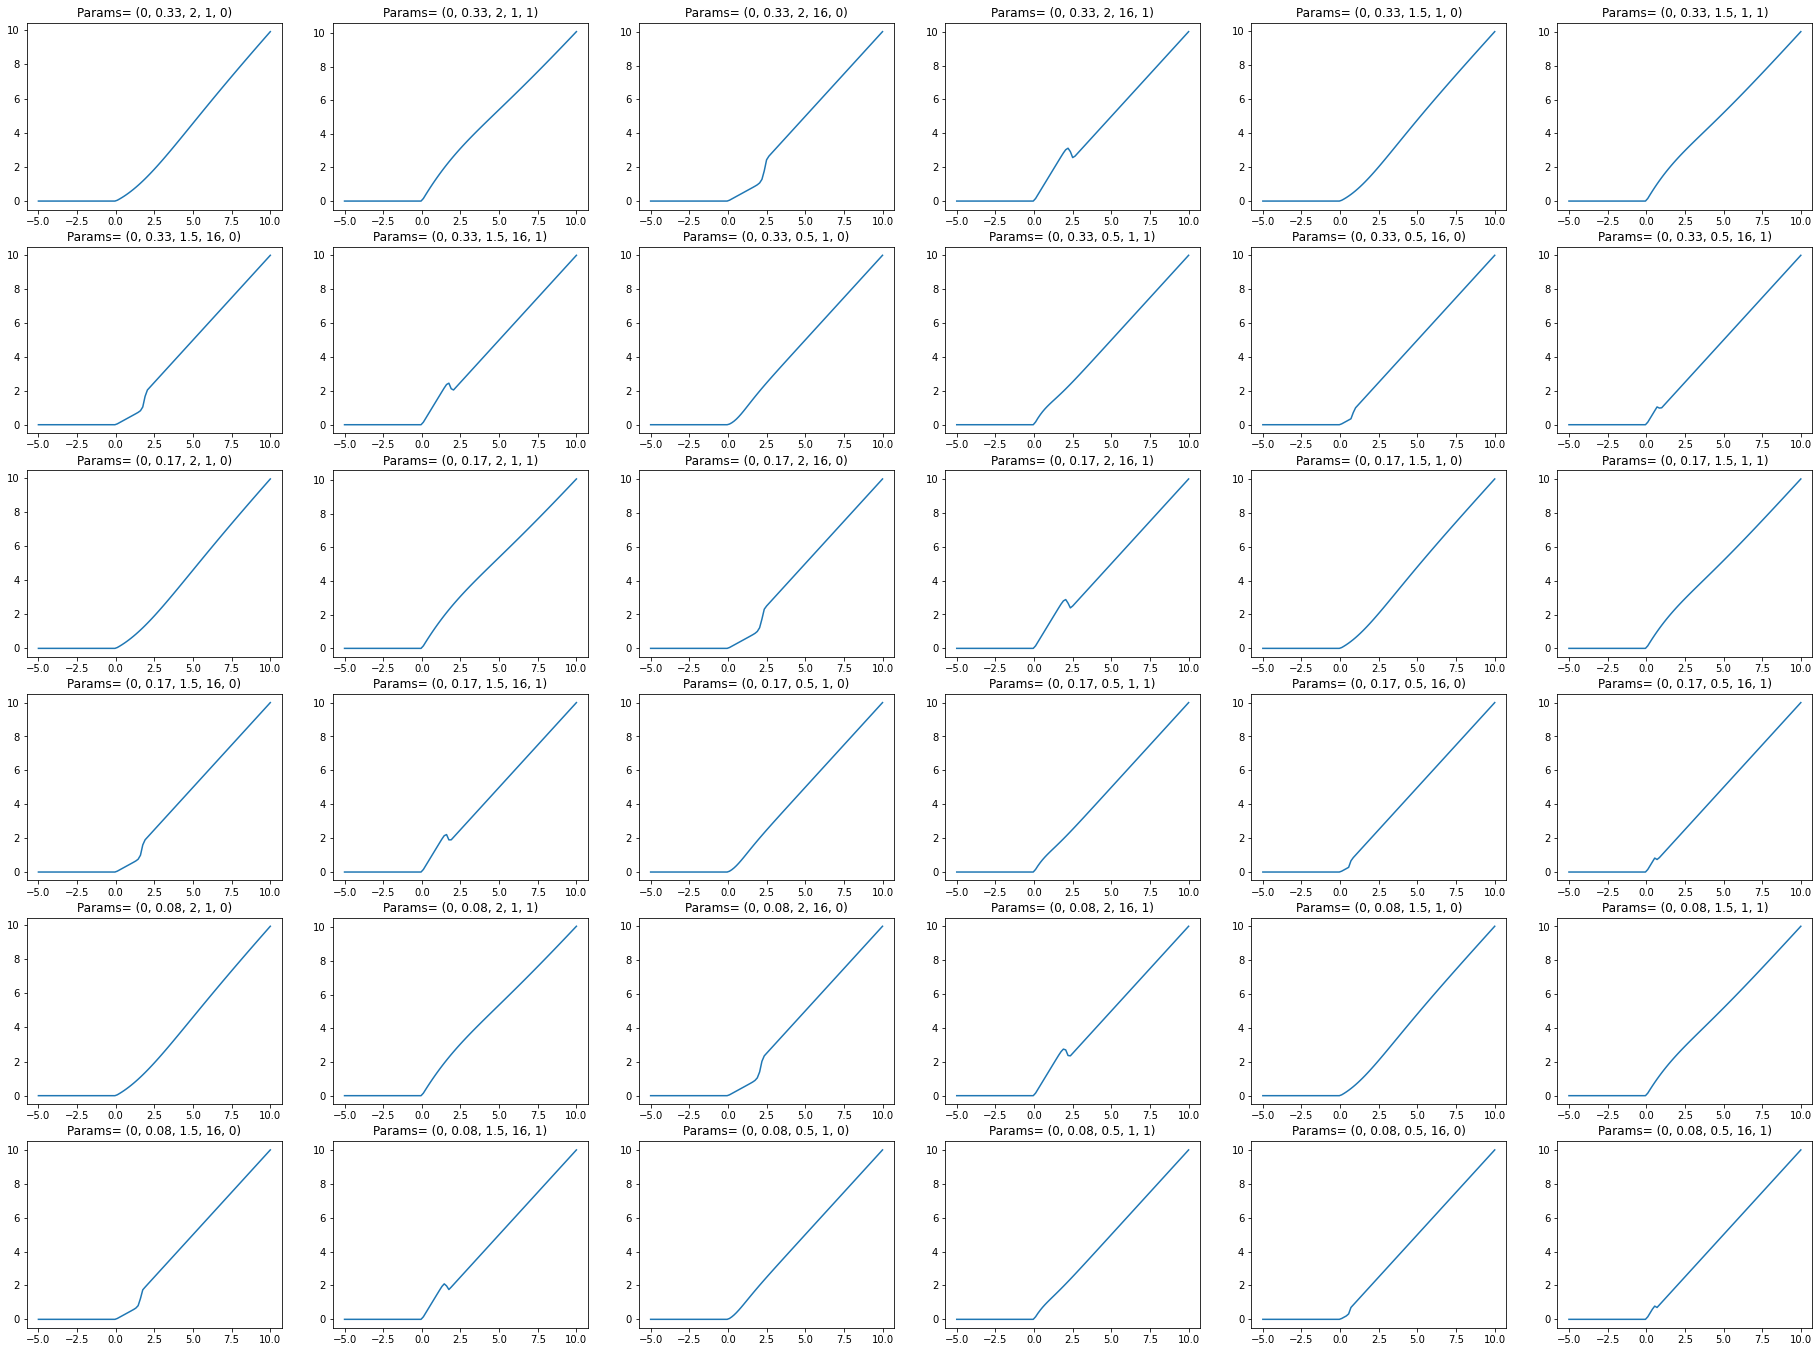

In [ ]:
x = np.linspace(-5, 10, 101)

lamb = 0
lamb_arr = [0]
mu = 1/3
mu_arr = [1/3, 1/6, 1/12]
sigma = 2
sigma_arr = [2, 1.5, 0.5]
beta = 1
beta_arr = [1, 16]
alpha = 0
alpha_arr = [0, 1]

combinations = list(itertools.product(lamb_arr, mu_arr, sigma_arr, beta_arr, alpha_arr))

fig, ax = plt.subplots(6, 6, figsize=(32, 24))
for id in range(36):
  comb = combinations[id]
  lamb, mu, sigma, beta, alpha = comb
  y = [RePSU(xx, lamb=lamb, mu=mu, sigma=sigma, beta=beta, alpha=alpha) for xx in x]

  ax[id//6, id%6].plot(x, y)
  ax[id//6, id%6].set_title("Params= ({}, {:.2f}, {}, {}, {})".format(comb[0], comb[1], comb[2], comb[3], comb[4]))

### Load MNIST dataset

In [ ]:
# load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# normalize the pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

### Shallow CNN

The shallow CNN has one input layer, one convolutional layer, one normalization layer, one custom layer, one fully connected layer, and one output layer for classification. The input shape of the convolutional layer is (28, 28, 1), which represents a 28x28 grayscale digit image. The activation function used in the convolutional and fully connected layers is ReLU, while the activation function used in the output layer is softmax for multi-class classification.

In [ ]:
def create_model(input_size=(28,28,1), cfs=(2,2), ncf=32, activation="relu"):

  # add the input layer
  input_layer = Input(input_size)

  # add the convolutional layer
  conv = Conv2D(ncf, cfs, activation='relu',  kernel_initializer = 'he_normal')(input_layer)

  # add normalization to the layers
  norm = BatchNormalization()(conv)

  # add the custom activation function layer
  if activation == "relu":
    custom = layers.Activation(activations.relu)(norm)
  elif activation == "mish":
    custom = layers.Activation(tfa.activations.mish)(norm)
  elif activation == "swish":
    custom = layers.Activation(tf.keras.activations.swish)(norm)
  elif activation == "prelu":
    custom = layers.Activation(ParametricReLU())(norm)
  elif activation == "pswish":
    custom = layers.Activation(ParametricSwish())(norm)
  elif activation == "pmish":
    custom = layers.Activation(ParametricMish())(norm)
  elif activation == "repsu":
    custom = layers.Activation(ParametricRePSU())(norm)
  else:
    custom = Lambda(activation)(norm)

  flat = Flatten()(custom)

  # add the fully connected layer with 32 neurons
  #fc = Dense(32, activation='relu', kernel_initializer = 'he_normal')(flat)

  # add the final output layer with 10 neurons and 'softmax' activation for classification
  output_layer = Dense(10, activation='softmax',  kernel_initializer = 'he_normal')(flat)

  model = Model(input_layer, output_layer)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model= create_model(input_size=(28,28,1), cfs=(2,2), ncf=10, activation="repsu")
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 10)        50        
                                                                 
 batch_normalization_11 (Bat  (None, 27, 27, 10)       40        
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 27, 27, 10)        5         
                                                                 
 flatten_7 (Flatten)         (None, 7290)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                72910     
                                                           

In [ ]:
# relu
hist = model.fit(x_train, y_train, batch_size=64, epochs=2, verbose=1, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/2
938/938 [==============================] - 12s 4ms/step - loss: 0.2838 - accuracy: 0.9170 - val_loss: 0.1611 - val_accuracy: 0.9541
Epoch 2/2
938/938 [==============================] - 4s 5ms/step - loss: 0.1381 - accuracy: 0.9612 - val_loss: 0.1206 - val_accuracy: 0.9647


In [ ]:
# prelu
hist = model.fit(x_train, y_train, batch_size=64, epochs=2, verbose=1, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/2
938/938 [==============================] - 5s 5ms/step - loss: 0.2753 - accuracy: 0.9184 - val_loss: 0.1656 - val_accuracy: 0.9534
Epoch 2/2
938/938 [==============================] - 4s 4ms/step - loss: 0.1330 - accuracy: 0.9622 - val_loss: 0.1303 - val_accuracy: 0.9618


In [ ]:
# pswish
hist = model.fit(x_train, y_train, batch_size=64, epochs=2, verbose=1, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/2
938/938 [==============================] - 5s 5ms/step - loss: 0.3088 - accuracy: 0.9123 - val_loss: 0.1606 - val_accuracy: 0.9532
Epoch 2/2
938/938 [==============================] - 4s 4ms/step - loss: 0.1250 - accuracy: 0.9647 - val_loss: 0.1117 - val_accuracy: 0.9671


In [ ]:
# pmish
hist = model.fit(x_train, y_train, batch_size=64, epochs=2, verbose=1, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/2
938/938 [==============================] - 8s 6ms/step - loss: 0.2035 - accuracy: 0.9399 - val_loss: 0.1145 - val_accuracy: 0.9644
Epoch 2/2
938/938 [==============================] - 5s 5ms/step - loss: 0.0800 - accuracy: 0.9752 - val_loss: 0.1116 - val_accuracy: 0.9671


In [ ]:
# repsu
hist = model.fit(x_train, y_train, batch_size=64, epochs=2, verbose=1, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/2
938/938 [==============================] - 12s 8ms/step - loss: 0.2125 - accuracy: 0.9362 - val_loss: 0.1152 - val_accuracy: 0.9667
Epoch 2/2
938/938 [==============================] - 7s 8ms/step - loss: 0.0812 - accuracy: 0.9762 - val_loss: 0.0963 - val_accuracy: 0.9707


### Load CIFAR-10 dataset

In [ ]:
# load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
# normalize the pixel values
#x_train, x_test = x_train / 255.0, x_test / 255.0

# convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True
    )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
test_generator = test_datagen.flow(x_test, y_test, batch_size=32)

### Shallow Ensemble Learning (SEL)

In [ ]:
def create_sel_model(activation="relu"):
  # Set the input shape
  input_shape = (32, 32, 3)

  # Define the input layer
  inputs = Input(shape=input_shape)

  # Resize the images to (299, 299, 3)
  resize = Lambda(lambda image: tf.image.resize(image, (128, 128)))(inputs)

  # Define the three branches of the model
  base_model1 = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=resize)
  output1 = base_model1.get_layer('top_activation').output
  #output1 = Reshape((9, 9, 1280))(output1)
  output1 = Flatten()(output1)

  base_model2 = NASNetMobile(include_top=False, weights='imagenet', input_tensor=resize)
  output2 = base_model2.get_layer('normal_concat_12').output
  output2 = Flatten()(output2)

  base_model3 = Xception(include_top=False, weights='imagenet', input_tensor=resize)
  output3 = base_model3.get_layer('add_11').output # add_11 not add_12
  output3 = Flatten()(output3)

  # Concatenate the outputs of the three branches
  concatenated = Concatenate()([output1, output2, output3])

  # add the custom activation function layer
  if activation == "mish":
    custom = layers.Activation(tfa.activations.mish)(concatenated)
  elif activation == "swish":
    custom = layers.Activation(tf.keras.activations.swish)(concatenated)
  elif activation == "prelu":
    custom = layers.Activation(ParametricReLU())(concatenated)
  elif activation == "pswish":
    custom = layers.Activation(ParametricSwish())(concatenated)
  elif activation == "pmish":
    custom = layers.Activation(ParametricMish())(concatenated)
  elif activation == "repsu":
    custom = layers.Activation(ParametricRePSU())(concatenated)
  elif activation == "repsku":
    custom = layers.Activation(ParametricRePSKU_no_beta())(concatenated)
  else:
    custom = layers.Activation(activations.relu)(concatenated)

  # Define the output layer
  #x = GlobalAveragePooling2D()(concatenated)
  x = Dense(10, activation='softmax', kernel_initializer = 'he_normal')(custom)

  model = Model(inputs=inputs, outputs=x)

  for layer in model.layers[:-6]:
      layer.trainable = False

  model.compile(optimizer= "adam", loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model = create_sel_model(activation="relu")

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
# Plot the model architecture
plot_model(model, to_file='combined_model.png', show_shapes=True)

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in model.layers][-8:]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Layer Type        Layer Name  \
0  <keras.layers.merging.concatenate.Concatenate ...  normal_concat_12   
1  <keras.layers.merging.add.Add object at 0x7f74...            add_11   
2  <keras.layers.reshaping.flatten.Flatten object...           flatten   
3  <keras.layers.reshaping.flatten.Flatten object...         flatten_1   
4  <keras.layers.reshaping.flatten.Flatten object...         flatten_2   
5  <keras.layers.merging.concatenate.Concatenate ...     concatenate_4   
6  <keras.layers.core.activation.Activation objec...    activation_188   
7  <keras.layers.core.dense.Dense object at 0x7f7...             dense   

   Layer Trainable  
0            False  
1            False  
2             True  
3             True  
4             True  
5             True  
6             True  
7             True

In [ ]:
model = create_sel_model(activation="relu")

In [ ]:
# relu 128x128
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 202s 113ms/step - loss: 10.0447 - accuracy: 0.7451 - val_loss: 3.7900 - val_accuracy: 0.8365


In [ ]:
model = create_sel_model(activation="repsku")

In [ ]:
# repsku 128x128 tf.math.greater assigning sigma 0.5 beta 1.0 clipping many epochs
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

Epoch 1/10
1562/1562 [==============================] - 188s 102ms/step - loss: 2.5278 - accuracy: 0.1056 - val_loss: 2.3026 - val_accuracy: 0.0997
Epoch 2/10
1562/1562 [==============================] - 170s 109ms/step - loss: 2.3028 - accuracy: 0.0972 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/10
1562/1562 [==============================] - 170s 109ms/step - loss: 2.3028 - accuracy: 0.1002 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 4/10
1562/1562 [==============================] - 168s 108ms/step - loss: 2.3028 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/10
1562/1562 [==============================] - 151s 97ms/step - loss: 2.3028 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 6/10
1562/1562 [==============================] - 168s 108ms/step - loss: 2.3028 - accuracy: 0.0975 - val_loss: 2.3027 - val_accuracy: 0.1001
Epoch 7/10
 932/1562 [================>.............] - ETA: 51s - loss: 2.3028 - accuracy: 0.0981

In [ ]:
# repsku 128x128 tf.math.greater assigning sigma 0.5 beta 1.0 clipping
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 199s 111ms/step - loss: 2.4261 - accuracy: 0.1969 - val_loss: 2.3026 - val_accuracy: 0.0999


In [ ]:
# repsku 128x128 tf.math.greater assigning sigma 0.5 beta 1.0
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 199s 111ms/step - loss: 2.5818 - accuracy: 0.1216 - val_loss: 2.3026 - val_accuracy: 0.1001


In [ ]:
# repsku 128x128 tf.math.greater assigning
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 189s 104ms/step - loss: 2.2975 - accuracy: 0.2347 - val_loss: 2.3026 - val_accuracy: 0.0999


In [ ]:
# repsku 128x128 tf.math.greater adam
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 187s 103ms/step - loss: 2.4115 - accuracy: 0.1683 - val_loss: 2.3027 - val_accuracy: 0.1000


In [ ]:
# repsku 128x128 tf.math.greater
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 183s 98ms/step - loss: 2.5028 - accuracy: 0.1546 - val_loss: 2.3026 - val_accuracy: 0.1000


In [ ]:
# repsku 128x128 no lambda
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 209s 115ms/step - loss: 4.6323 - accuracy: 0.2480 - val_loss: 2.3026 - val_accuracy: 0.1001


In [ ]:
# repsku 128x128 lambda
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 204s 113ms/step - loss: 2.5833 - accuracy: 0.1277 - val_loss: 2.3026 - val_accuracy: 0.0999


In [ ]:
model = create_sel_model(activation="pmish")

In [ ]:
# pmish 128x128
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 186s 104ms/step - loss: 8.5046 - accuracy: 0.7583 - val_loss: 3.0164 - val_accuracy: 0.8564


In [ ]:
model = create_sel_model(activation="pswish")

In [ ]:
# pswish 128x128
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 195s 110ms/step - loss: 4.6172 - accuracy: 0.7833 - val_loss: 4.5407 - val_accuracy: 0.8171


-----------------------------

In [ ]:
# relu 64x64
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 117s 56ms/step - loss: 4.6660 - accuracy: 0.6660 - val_loss: 3.9120 - val_accuracy: 0.6839


In [ ]:
# relu_sgd
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 116s 52ms/step - loss: 4.1115 - accuracy: 0.5320 - val_loss: 4.3109 - val_accuracy: 0.5592


In [ ]:
# relu_adam
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 130s 67ms/step - loss: 1.2653 - accuracy: 0.6197 - val_loss: 1.0139 - val_accuracy: 0.6899


In [ ]:
# pmish_sgd
model = create_sel_model(activation="pmish")

history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 107s 53ms/step - loss: 3.6663 - accuracy: 0.5468 - val_loss: 4.5003 - val_accuracy: 0.4657


In [ ]:
# pmish_adam
model = create_sel_model(activation="pmish")

history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 100s 49ms/step - loss: 1.2717 - accuracy: 0.6221 - val_loss: 1.0832 - val_accuracy: 0.6751


In [ ]:
# pswish_sgd
model = create_sel_model(activation="pswish")

history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 108s 54ms/step - loss: 2.5362 - accuracy: 0.5601 - val_loss: 2.1552 - val_accuracy: 0.5986


In [ ]:
# pswish_adam
model = create_sel_model(activation="pswish")

history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 98s 49ms/step - loss: 1.3196 - accuracy: 0.6169 - val_loss: 1.1170 - val_accuracy: 0.6690


In [ ]:
# repsu_sgd
model = create_sel_model(activation="repsu")

history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 112s 55ms/step - loss: 1.2235 - accuracy: 0.6097 - val_loss: 0.9428 - val_accuracy: 0.6680


In [ ]:
# repsu_adam
model = create_sel_model(activation="repsu")

history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=1,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

1562/1562 [==============================] - 120s 59ms/step - loss: 2.3052 - accuracy: 0.0993 - val_loss: 2.3026 - val_accuracy: 0.1001


## Deep Ensemble Learning

In [ ]:
def create_del_model(activation="relu"):
  # Set the input shape
  input_shape = (32, 32, 3)

  # Define the input layer
  inputs = Input(shape=input_shape)

  # Resize the images to (299, 299, 3)
  resized = Lambda(lambda image: tf.image.resize(image, (128, 128)))(inputs)

  # Define the three branches of the model
  base_model1 = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=resized)
  #output1 = base_model1.get_layer('top_activation').output
  output1 = base_model1.layers[237].output
  #output1 = Reshape((9, 9, 1280))(output1)
  output1 = Flatten()(output1)

  base_model2 = NASNetMobile(include_top=False, weights='imagenet', input_tensor=resized)
  #output2 = base_model2.get_layer('normal_concat_12').output
  output2 = base_model2.layers[767].output
  output2 = Flatten()(output2)

  base_model3 = Xception(include_top=False, weights='imagenet', input_tensor=resized)
  #output3 = base_model3.get_layer('add_11').output # add_11 not add_12
  output3 = base_model3.layers[130].output # add_11 not add_12
  output3 = Flatten()(output3)


  # add the custom_3 activation function layer
  if activation == "mish":
    custom_1 = layers.Activation(tfa.activations.mish)(output1)
    custom_2 = layers.Activation(tfa.activations.mish)(output2)
    custom_3 = layers.Activation(tfa.activations.mish)(output3)
  elif activation == "swish":
    custom_1 = layers.Activation(tf.keras.activations.swish)(output1)
    custom_2 = layers.Activation(tf.keras.activations.swish)(output2)
    custom_3 = layers.Activation(tf.keras.activations.swish)(output3)
  elif activation == "prelu":
    custom_1 = layers.Activation(ParametricReLU())(output1)
    custom_2 = layers.Activation(ParametricReLU())(output2)
    custom_3 = layers.Activation(ParametricReLU())(output3)
  elif activation == "pswish":
    custom_1 = layers.Activation(ParametricSwish())(output1)
    custom_2 = layers.Activation(ParametricSwish())(output2)
    custom_3 = layers.Activation(ParametricSwish())(output3)
  elif activation == "pmish":
    custom_1 = layers.Activation(ParametricMish())(output1)
    custom_2 = layers.Activation(ParametricMish())(output2)
    custom_3 = layers.Activation(ParametricMish())(output3)
  elif activation == "repsu":
    custom_1 = layers.Activation(ParametricRePSU())(output1)
    custom_2 = layers.Activation(ParametricRePSU())(output2)
    custom_3 = layers.Activation(ParametricRePSU())(output3)
  elif activation == "repsku":
    custom_1 = layers.Activation(ParametricRePSKU())(output1)
    custom_2 = layers.Activation(ParametricRePSKU())(output2)
    custom_3 = layers.Activation(ParametricRePSKU())(output3)
  else:
    custom_1 = layers.Activation(activations.relu)(output1)
    custom_2 = layers.Activation(activations.relu)(output2)
    custom_3 = layers.Activation(activations.relu)(output3)

  #custom_1= Dense(200, kernel_initializer = 'he_normal')(custom_1)
  #custom_2= Dense(200, kernel_initializer = 'he_normal')(custom_2)
  #custom_3= Dense(200, kernel_initializer = 'he_normal')(custom_3)

  # Concatenate the outputs of the three branches
  concatenated = Concatenate()([custom_1, custom_2, custom_3])

  # Define the output layer
  #x = GlobalAveragePooling2D()(concatenated)
  x = Dense(10, activation='softmax', kernel_initializer = 'he_normal')(concatenated)

  model = Model(inputs=inputs, outputs=x)

  #for layer in model.layers[:-6]:
  #    layer.trainable = False

  model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
del_model= create_del_model(activation="repsku")

In [ ]:
# repsku
history = del_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

In [ ]:
del_model= create_del_model(activation="pmish")

In [ ]:
# pmish
history = del_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

In [ ]:
del_model= create_del_model(activation="pswish")

In [ ]:
# pswish
history = del_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

-------


In [ ]:
del_model= create_del_model(activation="repsu")

In [ ]:
# relu
history = del_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

Epoch 1/10
1562/1562 [==============================] - 361s 164ms/step - loss: 1.4755 - accuracy: 0.4755 - val_loss: 2.9404 - val_accuracy: 0.1767
Epoch 2/10
 760/1562 [=============>................] - ETA: 1:57 - loss: 1.1395 - accuracy: 0.5972

In [ ]:
# repsu
history = del_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(x_test) // 32)

Epoch 1/10
1562/1562 [==============================] - 372s 168ms/step - loss: 1.4099 - accuracy: 0.5009 - val_loss: 1.9143 - val_accuracy: 0.2920
Epoch 2/10
1562/1562 [==============================] - 256s 164ms/step - loss: 1.0175 - accuracy: 0.6437 - val_loss: 1.8668 - val_accuracy: 0.4258
Epoch 3/10
1562/1562 [==============================] - 256s 164ms/step - loss: 0.8536 - accuracy: 0.7048 - val_loss: 1.6659 - val_accuracy: 0.6446
Epoch 4/10
1562/1562 [==============================] - 260s 166ms/step - loss: 0.7705 - accuracy: 0.7325 - val_loss: 10.1809 - val_accuracy: 0.6541
Epoch 5/10
1562/1562 [==============================] - 261s 167ms/step - loss: 0.6957 - accuracy: 0.7600 - val_loss: 1.6395 - val_accuracy: 0.6643
Epoch 6/10
 242/1562 [===>..........................] - ETA: 3:21 - loss: 0.6142 - accuracy: 0.7832

In [ ]:
# Plot the model architecture
plot_model(del_model, to_file='del_model.png', show_shapes=True)

## Deep CNN

In [ ]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 3.9 MB/s eta 0:00:00


In [ ]:
import patoolib

# specify the name of the split ZIP file
zip_filename = '/content/drive/MyDrive/IMT/UE-H 2022 2023/Dataset/gfbf/GFBF_CPLX_DATA_4Classes/GFBF_CPLX_DATA_4Classes.zip'

# extract the contents of the split ZIP file
patoolib.extract_archive(zip_filename, outdir='extracted')

patool: Extracting /content/gdrive/MyDrive/IMT/UE-H 2022 2023/Dataset/gfbf/GFBF_CPLX_DATA_4Classes/GFBF_CPLX_DATA_4Classes.zip ...
patool: running /usr/bin/7z x -oextracted -- "/content/gdrive/MyDrive/IMT/UE-H 2022 2023/Dataset/gfbf/GFBF_CPLX_DATA_4Classes/GFBF_CPLX_DATA_4Classes.zip"
patool: ... /content/gdrive/MyDrive/IMT/UE-H 2022 2023/Dataset/gfbf/GFBF_CPLX_DATA_4Classes/GFBF_CPLX_DATA_4Classes.zip extracted to `extracted'.


'extracted'

In [ ]:
import os
path= "/content/extracted/GFBF_CPLX_DATA_4Classes/"

class_folders= ["GFBF01/", "GFBF02/", "GFBF03/", "GFBF04/"]
imgs_list= []
targets_list= []

for f in class_folders:
  L= os.listdir(path + f)
  L= [path + f + x for x in L]
  imgs_list+= L
  targets_list+= [int(f[-2]) - 1] * len(L)


data_df = pd.DataFrame({'images': imgs_list, 'target': targets_list})

from sklearn.model_selection import train_test_split
data_train, data_val= train_test_split(data_df, test_size=0.2, shuffle= True, random_state= 43)
train_index= data_train.index.values
val_index= data_val.index.values
data_train= data_train.reset_index(drop=True)
data_val= data_val.reset_index(drop=True)

data_train

images  target
0     /content/extracted/GFBF_CPLX_DATA_4Classes/GFB...       2
1     /content/extracted/GFBF_CPLX_DATA_4Classes/GFB...       1
2     /content/extracted/GFBF_CPLX_DATA_4Classes/GFB...       0
3     /content/extracted/GFBF_CPLX_DATA_4Classes/GFB...       1
4     /content/extracted/GFBF_CPLX_DATA_4Classes/GFB...       1
...                                                 ...     ...
3835  /content/extracted/GFBF_CPLX_DATA_4Classes/GFB...       0
3836  /content/extracted/GFBF_CPLX_DATA_4Classes/GFB...       1
3837  /content/extracted/GFBF_CPLX_DATA_4Classes/GFB...       1
3838  /content/extracted/GFBF_CPLX_DATA_4Classes/GFB...       1
3839  /content/extracted/GFBF_CPLX_DATA_4Classes/GFB...       2

[3840 rows x 2 columns]

In [ ]:
# Image data generator class
class Custom_Data_Generator(tf.keras.utils.Sequence):

    def __init__(self, dataframe, batch_size, augment = False):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.augment = augment

    # Steps per epoch
    def __len__(self):
        #return (len(self.dataframe)-1) // self.batch_size
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    # Shuffles and resets the index at the end of training epoch
    def on_epoch_end(self):
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

    # Generates data, feeds to training
    def __getitem__(self, index):

        w= 128
        h= 128

        data= []
        targets= []

        for ba in range(self.batch_size):

            img_name=  self.dataframe['images'][self.batch_size * index + ba]
            tg= int(self.dataframe['target'][self.batch_size * index + ba])

            img= cv2.imread(img_name)
            img_resized= cv2.resize(img, (w, h))

            data.append(img_resized)
            targets.append(tg)

        batch_x= np.array(data, dtype=np.float32)
        batch_x= np.divide(batch_x, 255)
        batch_y= np.array(targets, dtype=np.float32)

        return batch_x, batch_y

In [ ]:
batch_size= 32
custom_gen_train= Custom_Data_Generator(data_train, batch_size, augment= False)
custom_gen_val= Custom_Data_Generator(data_val, batch_size, augment= False)

In [ ]:
sample= custom_gen_train.__getitem__(1)

0.0


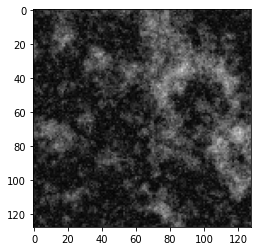

In [ ]:
print(sample[1][0])
plt.imshow(sample[0][0])

In [ ]:
def create_deepcnn_model(activation="relu"):
  # Set the input shape
  input_shape = (128, 128, 3)

  # Define the input layer
  input_layer = Input(shape=input_shape)

  # add the convolutional layer
  conv = Conv2D(96, (3, 3), kernel_initializer = 'he_normal', padding= "same", strides=2)(input_layer) # 96 64

  # add normalization to the layers
  norm = BatchNormalization()(conv)

  # add the custom activation function layer
  if activation == "mish":
    custom = layers.Activation(tfa.activations.mish)(norm)
  elif activation == "swish":
    custom = layers.Activation(tf.keras.activations.swish)(norm)
  elif activation == "prelu":
    custom = layers.Activation(ParametricReLU())(norm)
  elif activation == "pswish":
    custom = layers.Activation(ParametricSwish())(norm)
  elif activation == "pmish":
    custom = layers.Activation(ParametricMish())(norm)
  elif activation == "repsu":
    custom = layers.Activation(ParametricRePSU())(norm)
  elif activation == "repsku":
    custom = layers.Activation(ParametricRePSKU())(norm)
  else:
    custom = layers.Activation(activations.relu)(norm)

  # add convolutional & normalization layers
  conv = Conv2D(128, (5, 5), activation='relu', kernel_initializer = 'he_normal', padding="same", strides=2)(custom)
  norm = BatchNormalization()(conv)

  # add convolutional & normalization layers
  conv = Conv2D(384, (7, 7), activation='relu', kernel_initializer = 'he_normal', padding="same", strides=2)(norm) # 384 256
  norm = BatchNormalization()(conv)

  # add convolutional & normalization layers
  conv = Conv2D(192, (5, 5), activation='relu', kernel_initializer = 'he_normal', padding="same", strides=2)(norm) # 192 128
  norm = BatchNormalization()(conv)

  # add convolutional & normalization layers
  conv = Conv2D(128, (3, 3), activation='relu', kernel_initializer = 'he_normal', padding="same", strides=2)(norm)
  norm = BatchNormalization()(conv)
  flat = Flatten()(norm)

  # Define the dense layer
  #x= Dense(4096 // 4, activation='relu', kernel_initializer = 'he_normal')(flat)
  x = Dropout(0.6)(flat)

  # Define the output layer
  x = Dense(4, activation='softmax', kernel_initializer = 'he_normal')(x)

  model = Model(inputs=input_layer, outputs=x)

  model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

  return model

In [ ]:
deepcnn_model= create_deepcnn_model(activation="relu")

In [ ]:
deepcnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 96)        2688      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       307328    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                             

In [ ]:
deepcnn_model= create_deepcnn_model(activation="relu")

In [ ]:
# relu
history = deepcnn_model.fit(custom_gen_train,
                    validation_data= custom_gen_val,
                    epochs=10,
                    validation_steps= len(data_val) // batch_size,
                    steps_per_epoch= len(data_train) //batch_size)

Epoch 1/10
120/120 [==============================] - 77s 614ms/step - loss: 1.6004 - accuracy: 0.4482 - val_loss: 2.0299 - val_accuracy: 0.2615
Epoch 2/10
120/120 [==============================] - 73s 608ms/step - loss: 1.0639 - accuracy: 0.5909 - val_loss: 1.9788 - val_accuracy: 0.2906
Epoch 3/10
120/120 [==============================] - 74s 616ms/step - loss: 0.8231 - accuracy: 0.6779 - val_loss: 1.2918 - val_accuracy: 0.4625
Epoch 4/10
120/120 [==============================] - 72s 604ms/step - loss: 0.6134 - accuracy: 0.7638 - val_loss: 1.0910 - val_accuracy: 0.5010
Epoch 5/10
120/120 [==============================] - 72s 598ms/step - loss: 0.4272 - accuracy: 0.8372 - val_loss: 1.1433 - val_accuracy: 0.5063
Epoch 6/10
120/120 [==============================] - 74s 615ms/step - loss: 0.2961 - accuracy: 0.8924 - val_loss: 1.2097 - val_accuracy: 0.5250
Epoch 7/10
120/120 [==============================] - 72s 603ms/step - loss: 0.1863 - accuracy: 0.9365 - val_loss: 1.2287 - val_ac

In [ ]:
deepcnn_model= create_deepcnn_model(activation="repsku")

In [ ]:
# repsku
history = deepcnn_model.fit(custom_gen_train,
                    validation_data= custom_gen_val,
                    epochs=10,
                    validation_steps= len(data_val) // batch_size,
                    steps_per_epoch= len(data_train) //batch_size)

Epoch 1/10
120/120 [==============================] - 79s 617ms/step - loss: 1.5787 - accuracy: 0.4672 - val_loss: 2.1449 - val_accuracy: 0.2823
Epoch 2/10
120/120 [==============================] - 79s 657ms/step - loss: 1.0739 - accuracy: 0.5867 - val_loss: 1.7614 - val_accuracy: 0.3167
Epoch 3/10
120/120 [==============================] - 79s 658ms/step - loss: 0.7877 - accuracy: 0.6974 - val_loss: 1.5355 - val_accuracy: 0.3875
Epoch 4/10
120/120 [==============================] - 78s 653ms/step - loss: 0.5585 - accuracy: 0.7893 - val_loss: 1.1197 - val_accuracy: 0.4938
Epoch 5/10
120/120 [==============================] - 75s 628ms/step - loss: 0.3864 - accuracy: 0.8510 - val_loss: 1.2893 - val_accuracy: 0.5229
Epoch 6/10
120/120 [==============================] - 75s 625ms/step - loss: 0.2466 - accuracy: 0.9049 - val_loss: 1.3005 - val_accuracy: 0.5302
Epoch 7/10
120/120 [==============================] - 75s 629ms/step - loss: 0.1673 - accuracy: 0.9461 - val_loss: 1.2537 - val_ac

In [ ]:
deepcnn_model= create_deepcnn_model(activation="pmish")

In [ ]:
# pmish
history = deepcnn_model.fit(custom_gen_train,
                    validation_data= custom_gen_val,
                    epochs=10,
                    validation_steps= len(data_val) // batch_size,
                    steps_per_epoch= len(data_train) //batch_size)

Epoch 1/10
120/120 [==============================] - 77s 615ms/step - loss: 1.6047 - accuracy: 0.4521 - val_loss: 1.8131 - val_accuracy: 0.2604
Epoch 2/10
120/120 [==============================] - 74s 617ms/step - loss: 0.9830 - accuracy: 0.6094 - val_loss: 1.6195 - val_accuracy: 0.2792
Epoch 3/10
120/120 [==============================] - 74s 616ms/step - loss: 0.7681 - accuracy: 0.6966 - val_loss: 1.3093 - val_accuracy: 0.4573
Epoch 4/10
120/120 [==============================] - 79s 658ms/step - loss: 0.5170 - accuracy: 0.7979 - val_loss: 1.1637 - val_accuracy: 0.5104
Epoch 5/10
120/120 [==============================] - 72s 601ms/step - loss: 0.3715 - accuracy: 0.8576 - val_loss: 1.1017 - val_accuracy: 0.5365
Epoch 6/10
120/120 [==============================] - 71s 591ms/step - loss: 0.2608 - accuracy: 0.9083 - val_loss: 1.2229 - val_accuracy: 0.5375
Epoch 7/10
120/120 [==============================] - 71s 590ms/step - loss: 0.1986 - accuracy: 0.9305 - val_loss: 1.2241 - val_ac

In [ ]:
deepcnn_model= create_deepcnn_model(activation="pswish")

In [ ]:
# pswish
history = deepcnn_model.fit(custom_gen_train,
                    validation_data= custom_gen_val,
                    epochs=10,
                    validation_steps= len(data_val) // batch_size,
                    steps_per_epoch= len(data_train) //batch_size)

Epoch 1/10
120/120 [==============================] - 77s 616ms/step - loss: 1.6227 - accuracy: 0.4563 - val_loss: 2.2100 - val_accuracy: 0.2521
Epoch 2/10
120/120 [==============================] - 72s 603ms/step - loss: 1.0855 - accuracy: 0.5852 - val_loss: 1.8617 - val_accuracy: 0.2990
Epoch 3/10
120/120 [==============================] - 72s 603ms/step - loss: 0.8840 - accuracy: 0.6648 - val_loss: 1.2160 - val_accuracy: 0.4563
Epoch 4/10
120/120 [==============================] - 73s 608ms/step - loss: 0.6757 - accuracy: 0.7339 - val_loss: 1.0206 - val_accuracy: 0.5396
Epoch 5/10
120/120 [==============================] - 77s 642ms/step - loss: 0.4952 - accuracy: 0.8125 - val_loss: 1.1563 - val_accuracy: 0.5146
Epoch 6/10
120/120 [==============================] - 78s 655ms/step - loss: 0.3463 - accuracy: 0.8714 - val_loss: 1.2135 - val_accuracy: 0.5333
Epoch 7/10
120/120 [==============================] - 72s 601ms/step - loss: 0.2513 - accuracy: 0.9076 - val_loss: 1.2879 - val_ac

-------------------------------------

In [ ]:
import cv2

im = cv2.imread("/content/extracted/GFBF_CPLX_DATA_4Classes/GFBF01/FieldCPLX-1Facteurs_Conv2_PoleGamma_HurstConstant_Siz1024x1024_MC1.tif")

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True
    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory= "/content/extracted/GFBF_CPLX_DATA_4Classes/",
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42)

Found 4800 images belonging to 4 classes.


In [ ]:
input_shape = (32, 32, 3)

# Define the input layer
inputs = Input(shape=input_shape)

base_model3 = Xception(include_top=False, weights='imagenet')

base_model2 = NASNetMobile(include_top=False, weights='imagenet', input_tensor=inputs)

base_model1 = EfficientNetB0(include_top=False, weights='imagenet')
{i: v.name for i,v in enumerate(base_model2.layers)}

{0: 'input_14',
 1: 'stem_conv1',
 2: 'stem_bn1',
 3: 'activation_571',
 4: 'reduction_conv_1_stem_1',
 5: 'reduction_bn_1_stem_1',
 6: 'activation_572',
 7: 'activation_574',
 8: 'separable_conv_1_pad_reduction_left1_stem_1',
 9: 'separable_conv_1_pad_reduction_right1_stem_1',
 10: 'separable_conv_1_reduction_left1_stem_1',
 11: 'separable_conv_1_reduction_right1_stem_1',
 12: 'separable_conv_1_bn_reduction_left1_stem_1',
 13: 'separable_conv_1_bn_reduction_right1_stem_1',
 14: 'activation_573',
 15: 'activation_575',
 16: 'separable_conv_2_reduction_left1_stem_1',
 17: 'separable_conv_2_reduction_right1_stem_1',
 18: 'activation_576',
 19: 'separable_conv_2_bn_reduction_left1_stem_1',
 20: 'separable_conv_2_bn_reduction_right1_stem_1',
 21: 'separable_conv_1_pad_reduction_right2_stem_1',
 22: 'activation_578',
 23: 'reduction_add_1_stem_1',
 24: 'separable_conv_1_reduction_right2_stem_1',
 25: 'separable_conv_1_pad_reduction_right3_stem_1',
 26: 'activation_580',
 27: 'separable_conv

----------------------------------

### Download the generated GFBF dataset

In [ ]:
path = "/content/drive/MyDrive/UE-H 2022 2023/"

In [ ]:
url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/7rjyfn5bgg-1.zip"
gfbf = wget.download(url)

In [ ]:
# Extract the contents of the zip file to a new folder
with zipfile.ZipFile('7rjyfn5bgg-1.zip', 'r') as zip_ref:
    zip_ref.extractall(path+'Dataset/gfbf/')

### Multiple scenario testing

In [ ]:
list_cfs = [(n,n) for n in [2, 3, 4, 5, 6, 7]]
list_ncf = [10, 20, 30, 40, 50]
#list_epochs = [1, 2]
num_trials = 1

1. ReLU activation function



In [ ]:
ep = 1
for ncf in list_ncf:
    for cfs in list_cfs:

      train_accuracies = np.zeros(num_trials)
      test_accuracies = np.zeros(num_trials)

      for i in range(num_trials):

        print(f"Trial={i} // EPOCH={ep} / NCF={ncf} / CFS = {cfs}")

        shallow_cnn = create_model(cfs=cfs, ncf=ncf)

        # Fit the model on the training data
        history = shallow_cnn.fit(x_train, y_train, batch_size=64, epochs=ep, verbose=1, validation_data=(x_test, y_test))

        train_accuracies[i] = history.history['accuracy'][0]
        test_accuracies[i] = history.history['val_accuracy:'][0]
        print()

      mean_train_accuracy = np.mean(train_accuracies) * 100
      mean_test_accuracy = np.mean(test_accuracies) * 100
      print("Mean accuracy over 100 Monte Carlo trials: \t Train: {:.2f} | Test: {:.2f}".format(mean_train_accuracy, mean_test_accuracy))


      print("*+*"*50)

Trial=0 // EPOCH=1 / NCF=10 / CFS = (2, 2)
938/938 [==============================] - 4s 4ms/step - loss: 0.1909 - accuracy: 0.9421 - val_loss: 0.1007 - val_accuracy: 0.9681

Mean accuracy over 100 Monte Carlo trials: 94.21
*+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+*
Trial=0 // EPOCH=1 / NCF=10 / CFS = (3, 3)
938/938 [==============================] - 5s 5ms/step - loss: 0.1981 - accuracy: 0.9406 - val_loss: 0.1124 - val_accuracy: 0.9657

Mean accuracy over 100 Monte Carlo trials: 94.06
*+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+**+*
Trial=0 // EPOCH=1 / NCF=10 / CFS = (4, 4)
938/938 [==============================] - 4s 4ms/step - loss: 0.1951 - accuracy: 0.9423 - val_loss: 0.0903 - val_accuracy: 0.9730

Mean accuracy over 100 Monte Carlo trials: 94.23
*+**+**+**+**+**+**+**+**+

In [ ]:
model= create_model(input_size=(28,28,1), cfs=(2,2), ncf=10, activation="swish")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 27, 27, 10)        50        
                                                                 
 batch_normalization_4 (Batc  (None, 27, 27, 10)       40        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 27, 27, 10)        0         
                                                                 
 flatten_2 (Flatten)         (None, 7290)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                233312    
                                                           

In [ ]:
hist = model.fit(x_train, y_train, batch_size=64, epochs=2, verbose=1, shuffle=True, validation_data=(x_test, y_test))

Epoch 1/2
938/938 [==============================] - 5s 5ms/step - loss: 0.1790 - accuracy: 0.9443 - val_loss: 0.0904 - val_accuracy: 0.9725
Epoch 2/2
938/938 [==============================] - 5s 5ms/step - loss: 0.0599 - accuracy: 0.9815 - val_loss: 0.0920 - val_accuracy: 0.9720
